In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [23]:
import pandas as pd
import numpy as np
from knn import ParzenKNN, EuclideanMetric
from sklearn.model_selection import train_test_split
from utils import LOO_grid_search, kernel_function, MetricsEstimator

In [4]:
dataset = pd.read_csv("processed_dataset.csv", index_col=0)
dataset = (
    dataset.drop_duplicates()
)  # чтобы не было двух одинаковых точек (тогда dist=0)

X = dataset.drop(columns="RainTomorrow").to_numpy()
y = dataset["RainTomorrow"].to_numpy()

samples_idx = np.random.choice(len(X), 1000, replace=False)
X = X[samples_idx]
y = y[samples_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Подбор параметра k с помощью LOO

In [5]:
params = {
    "k": [i for i in range(1, 100, 2)],
    "metric_estimator": [EuclideanMetric()],
    "kernel_function": [kernel_function],
}

params_results = LOO_grid_search(ParzenKNN, params, X_train, y_train)

100%|██████████| 800/800 [00:01<00:00, 495.83it/s]


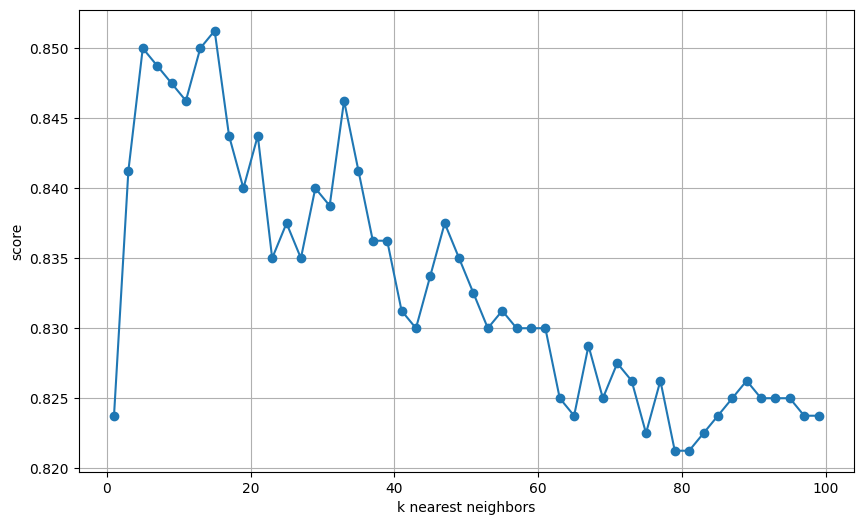

In [6]:
import matplotlib.pyplot as plt

k = []
score = []
for params in params_results["results"]:
    k.append(params["params"]["k"])
    score.append(params["score"])


plt.figure(figsize=(10, 6))
plt.plot(k, score, marker="o")
plt.grid()
plt.xlabel("k nearest neighbors")
plt.ylabel("score")
plt.show()

In [7]:
print(params_results["best_params"])
print(params_results["best_score"])

{'k': 15, 'metric_estimator': <knn.EuclideanMetric object at 0x11e465ee0>, 'kernel_function': <function kernel_function at 0x11ba253a0>}
0.85125


# Инициализируем лучшую модель

In [24]:
model = ParzenKNN(
    k=15, metric_estimator=EuclideanMetric(), kernel_function=kernel_function
)

predictions = model.predict_bathced(X_test, X_train, y_train)

100%|██████████| 200/200 [00:00<00:00, 459.17it/s]


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test.astype(str), predictions)

0.81

In [34]:
metric_estimator = MetricsEstimator()

metric_estimator.get_metrics(y_test, predictions.astype(int))

print(metric_estimator)

accuracy = 0.81
precision = 0.7727272727272727
recall = 0.34
f1_score = 0.47222222222222227


# Сравнение с эталонным алгоритмом

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from typing import Callable


def make_weights_function(k: int, kernel_function: Callable):
    def decorator(func):
        def wrapper(distances):
            return func(distances, k, kernel_function)

        return wrapper

    return decorator


@make_weights_function(k=15, kernel_function=np.vectorize(kernel_function))
def weights_function(
    distances: np.ndarray, k: int, kernel_function: Callable
) -> np.ndarray:
    max_distances = distances[:, -1].reshape(-1, 1)
    return kernel_function(distances / max_distances)


sklearn_model = KNeighborsClassifier(n_neighbors=15, weights=weights_function)
sklearn_model.fit(X_train, y_train)

sklearn_predictions = sklearn_model.predict(X_test)

In [36]:
accuracy_score(y_test, sklearn_predictions)

0.81

In [37]:
metric_estimator.get_metrics(y_test, sklearn_predictions)
print(metric_estimator)

accuracy = 0.81
precision = 0.7727272727272727
recall = 0.34
f1_score = 0.47222222222222227


# Отбор эталонных кандидатов

  0%|          | 0/800 [00:00<?, ?it/s]

 90%|█████████ | 720/800 [23:48<02:38,  1.98s/it] 


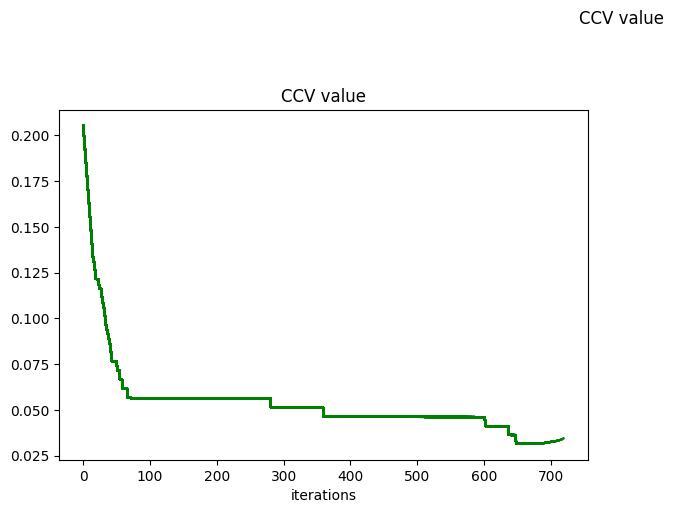

In [13]:
from utils import select_anchors

anchor_objects_indices = select_anchors(
    3, X_train, y_train, n_samples_to_estimate=200, plot=True, stop_threshold=0.01
)

In [38]:
predictions = model.predict_bathced(
    X_test, X_train[anchor_objects_indices], y_train[anchor_objects_indices]
)

print(accuracy_score(y_test.astype(str), predictions))

100%|██████████| 200/200 [00:00<00:00, 4088.55it/s]

0.765


In [40]:
metric_estimator.get_metrics(y_test, predictions.astype(int))
print(metric_estimator)

accuracy = 0.765
precision = 0.6153846153846154
recall = 0.16
f1_score = 0.253968253968254


# Визуализация эталонных объектов

## Для двумерного изображения выполним понижение размерности с помощью t-SNE

[]

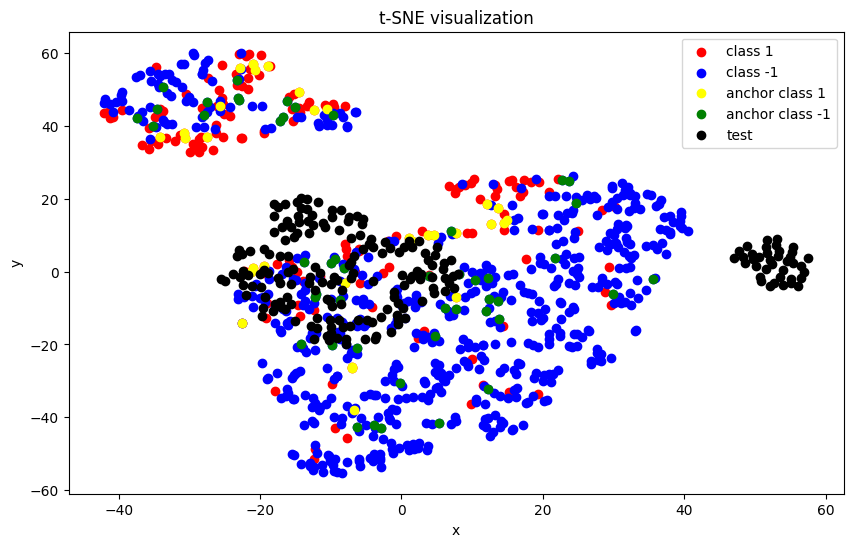

In [54]:
from sklearn.manifold import TSNE

X_train_reduced = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=15
).fit_transform(X_train)
X_test_reduced = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=15
).fit_transform(X_test)
anchor_objects_reduced = X_train_reduced[anchor_objects_indices]
anchor_objects_classes = y_train[anchor_objects_indices]

plt.figure(figsize=(10, 6))
plt.scatter(
    X_train_reduced[y_train == 1][:, 0],
    X_train_reduced[y_train == 1][:, 1],
    c="red",
    label="class 1",
)
plt.scatter(
    X_train_reduced[y_train == -1][:, 0],
    X_train_reduced[y_train == -1][:, 1],
    c="blue",
    label="class -1",
)
plt.scatter(
    anchor_objects_reduced[anchor_objects_classes == 1][:, 0],
    anchor_objects_reduced[anchor_objects_classes == 1][:, 1],
    c="yellow",
    label="anchor class 1",
)
plt.scatter(
    anchor_objects_reduced[anchor_objects_classes == -1][:, 0],
    anchor_objects_reduced[anchor_objects_classes == -1][:, 1],
    c="green",
    label="anchor class -1",
)
plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c="black", label="test")
plt.legend()
plt.title("t-SNE visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.plot()